In [1]:
%matplotlib inline
from obspy import read_inventory
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tempmatch as tm
from obspy import UTCDateTime as UTC
from obspy.signal import filter
import obspy

import scipy.stats as stats

In [2]:
def get_stream(paths):
    stream = obspy.read(paths[0])
    for p in paths[1:]:
        stream = stream + obspy.read(p)
        
    stream[3].data = -1 * stream[3].data
    return stream

In [3]:
paths = [
'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.{year}.{day}',
'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.02.GDH.{year}.{day}',
'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.03.GDH.{year}.{day}',
'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.04.GDH.{year}.{day}',
'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.05.GDH.{year}.{day}',
'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.06.GDH.{year}.{day}'
]
day_index = ['138', '140', '221', '222', '272', '274', '342']

streams = []
for day in day_index:
    stream = get_stream(paths=[p.format(day=day, year='2019') for p in paths])
    streams.append(stream)
    
# need to remember the last day
streams.append(get_stream(paths=[p.format(day='010', year='2020') for p in paths]))

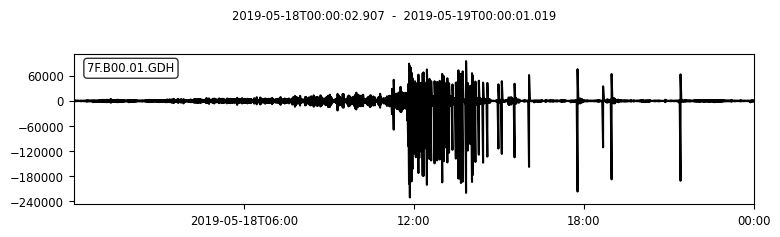

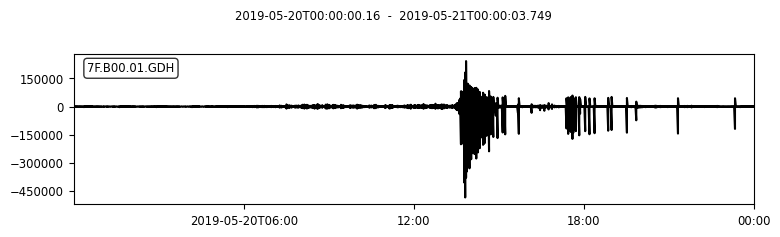

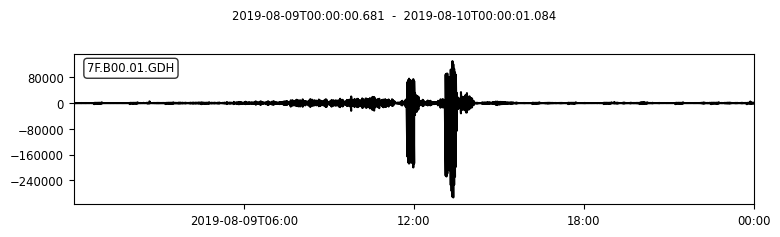

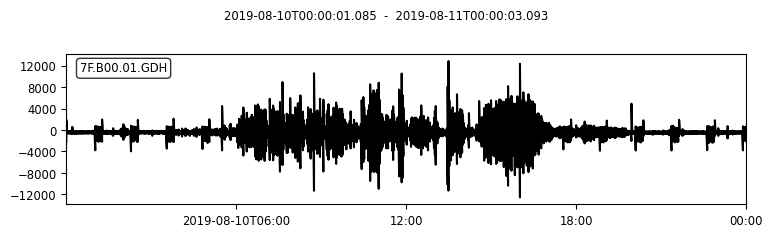

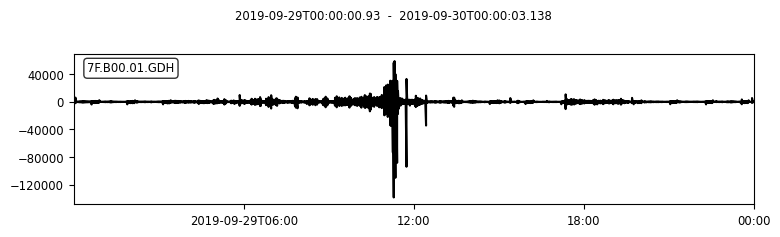

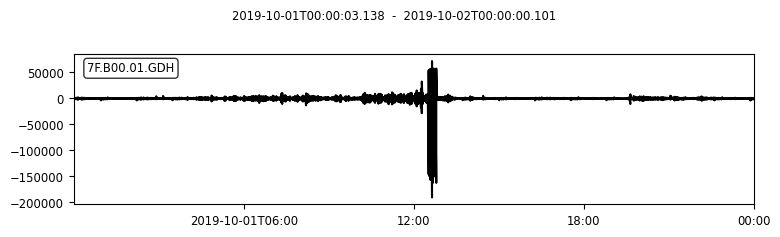

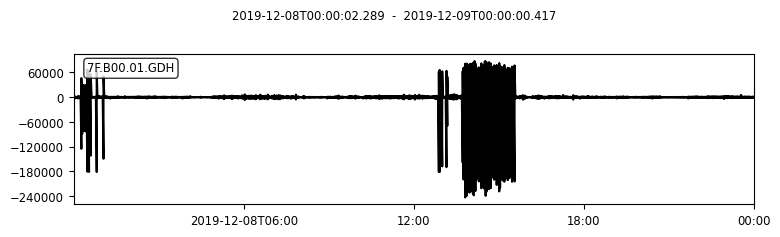

In [4]:
for n, i in enumerate(day_index):
    _ = streams[n][0].plot()

In [5]:
def get_std(stream, length_step):
    stream_copy = stream.copy()
    dfstd = pd.DataFrame()
    for window in stream_copy.slide(window_length=length_step, step=length_step):
        dfwindow = pd.DataFrame(window.std()).transpose()
        dfwindow.index = (window[0].stats['starttime'],)
        dfstd = pd.concat([dfstd, dfwindow])
    dfstd.columns = ['h0', 'h1', 'h2', 'h3', 'h4', 'h5']
    return dfstd

In [6]:
stds = [get_std(stream=s, length_step=60.0) for s in streams]

In [7]:
stds[0].head()

,h0,h1,h2,h3,h4,h5
2019-05-18T00:00:02.907000Z,266.063377,270.726584,285.564901,351.826397,417.330851,431.134050
2019-05-18T00:01:01.540000Z,203.141237,241.915603,260.550962,314.228862,352.788471,386.663455
2019-05-18T00:02:01.540000Z,291.894228,351.670666,424.082464,448.566543,531.699946,581.638853
2019-05-18T00:03:01.540000Z,156.146297,193.184860,204.830372,251.590159,270.627390,305.481677
2019-05-18T00:04:01.540000Z,155.912258,155.794676,169.133714,199.381632,246.303305,253.675198


In [8]:
len(stds)

8

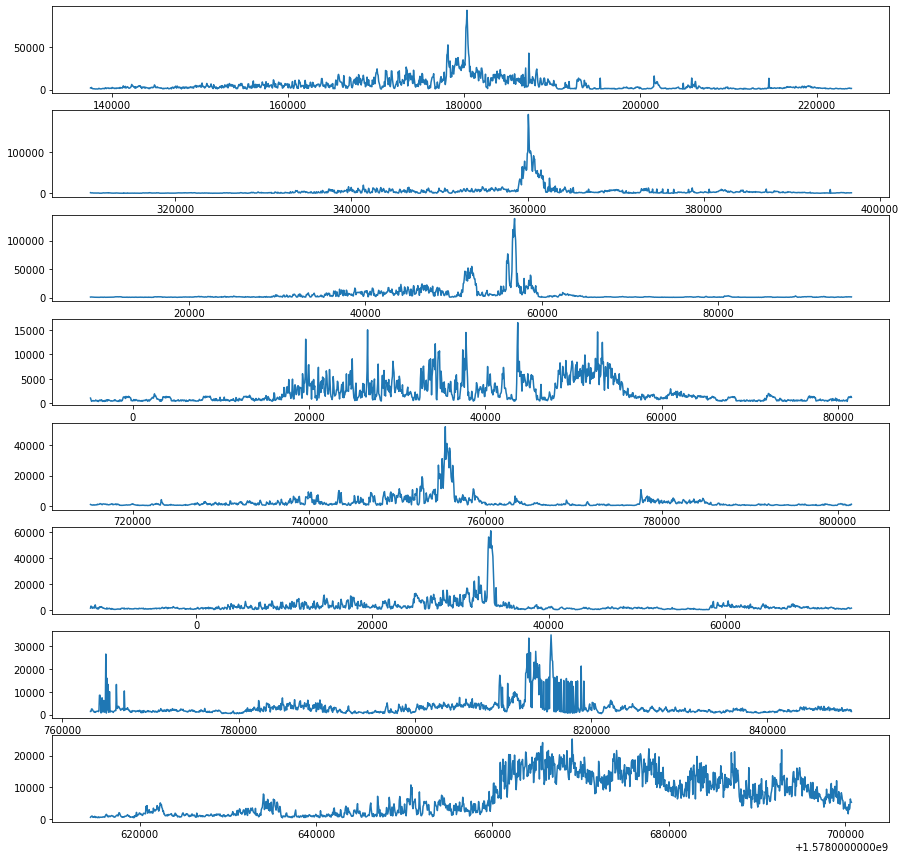

In [9]:
fig, ax = plt.subplots(8, 1, figsize=(15, 15))

for n, s in enumerate(stds):
    ax[n].plot(s.index, s.sum(axis=1))
    # ax[n].set_yscale('log')
    
# This represents the standard deviation calcualted for 60s sliding window (no overlap)
# for the first degassing event. You can see a clear increase in the RMS from the start
# of the day until the end start of the event. The top panel is the entire day and the
# bottom panel is a zoom up until the onset of the degassing event. The next step should
# be to produce this for the other degassing events. Note, the signals are stacked from
# all six hydrophones.

In [10]:
fig, ax = plt.subplots(8, 1, figsize=(15, 20))
# ax2 = ax.twinx().twiny()

def min_max(data):
    min = data.min()
    max = data.max()
    return (data - min)/(max - min)

def get_yt_yt2(stream, std):
    t = stream[0].times()
    y = min_max(stream[0].data)
    y2 = min_max(std.sum(axis=1))
    t2 = y2.index
    return y, t, y2, t2

def plot_yt_yt2(y, t, y2, t2, ax):
    ax.plot(t, y, color='black', alpha=0.5)
    ax2 = ax.twinx().twiny()
    ax2.plot(t2, y2, color='red')
    ax.spines['bottom'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)


for n, s in enumerate(stds):
    y, t, y2, t2 = get_yt_yt2(stream=streams[n], std=stds[n])
    plot_yt_yt2(y=y, t=t, y2=y2, t2=t2, ax=ax[n])
    del y, t, y2, t2

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig('rawstds.pdf', bbox_inches='tight')
plt.close()

In [11]:
# s = streams[0].copy()
# s.filter(freqmin=5.0, freqmax=10.0, type='bandpass')

In [12]:
# ax2 = ax.twinx().twiny()

streams_bp = [s.copy().filter(freqmin=5.0, freqmax=10.0, type='bandpass') for s in streams]

stds_bandpass5_10 = [get_std(stream=s, length_step=60.0) for s in streams_bp]

In [13]:
fig, ax = plt.subplots(8, 1, figsize=(15, 20))

def plot_yt_yt2(y, t, y2, t2, ax):
    ax.plot(t, y, color='black', alpha=0.5)
    ax2 = ax.twinx().twiny()
    ax2.plot(t2, y2, color='dodgerblue')
    ax.spines['bottom'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)

for n, s in enumerate(stds):
    y, t, y2, t2 = get_yt_yt2(stream=streams_bp[n], std=stds_bandpass5_10[n])
    plot_yt_yt2(y=y, t=t, y2=y2, t2=t2, ax=ax[n])
    del y, t, y2, t2

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig('bp510stds.pdf', bbox_inches='tight')
plt.close()
del streams_bp, stds_bandpass5_10

In [14]:
# ax2 = ax.twinx().twiny()

streams_bp = [s.copy().filter(freqmin=6.0, freqmax=8.0, type='bandpass') for s in streams]

stds_bandpass5_10 = [get_std(stream=s, length_step=60.0) for s in streams_bp]

In [15]:
fig, ax = plt.subplots(8, 1, figsize=(15, 20))

def plot_yt_yt2(y, t, y2, t2, ax):
    ax.plot(t, y, color='black', alpha=0.5)
    ax2 = ax.twinx().twiny()
    ax2.plot(t2, y2, color='darkorange')
    ax.spines['bottom'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)

for n, s in enumerate(stds):
    y, t, y2, t2 = get_yt_yt2(stream=streams_bp[n], std=stds_bandpass5_10[n])
    plot_yt_yt2(y=y, t=t, y2=y2, t2=t2, ax=ax[n])
    del y, t, y2, t2

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig('bp68stds.pdf', bbox_inches='tight')
plt.close()
del streams_bp, stds_bandpass5_10